<a href="https://colab.research.google.com/github/shuuuuyu/113-2-Generative-AI/blob/main/assignment_8_AI_Agents%EF%BC%9A%E6%89%93%E9%80%A0%E4%BD%A0%E5%B0%88%E5%B1%AC%E7%9A%84%E8%B6%85%E7%B4%9A%E4%BB%A3%E7%90%86%E4%BA%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 任務說明

將「排讀書行程」任務改寫為 Chain-of-Thought（CoT）推理過程。

**原始任務：** 輸入考試時間與讀書需求，自動生成一份合理的讀書時程表。

---

### ✅ CoT 改寫版本流程（排讀書行程機器人）

1. **第一階段（思考階段）**
   請 LLM 依序思考以下問題以理解任務需求：

   * 我有哪些空閒時間？（從給定的行程表中找出可用時間）
   * 我有哪些考試？每科考試是幾號？每科需要準備多少小時？
   * 是否有優先順序？（例如某些科更難，先安排）
   * 要怎麼拆分讀書時間（幾小時/天、間隔天數等）
   * 是否需要預留複習時間或緩衝？

2. **第二階段（產表階段）**

   * 根據第一階段的思考，將讀書時間分配到空閒時間中，形成完整排程表
   * 回傳一份格式清晰的時程表（建議用 Markdown 表格）
   * 若有衝突或時間不足，也請說明問題並給出建議



## 成果截圖
- 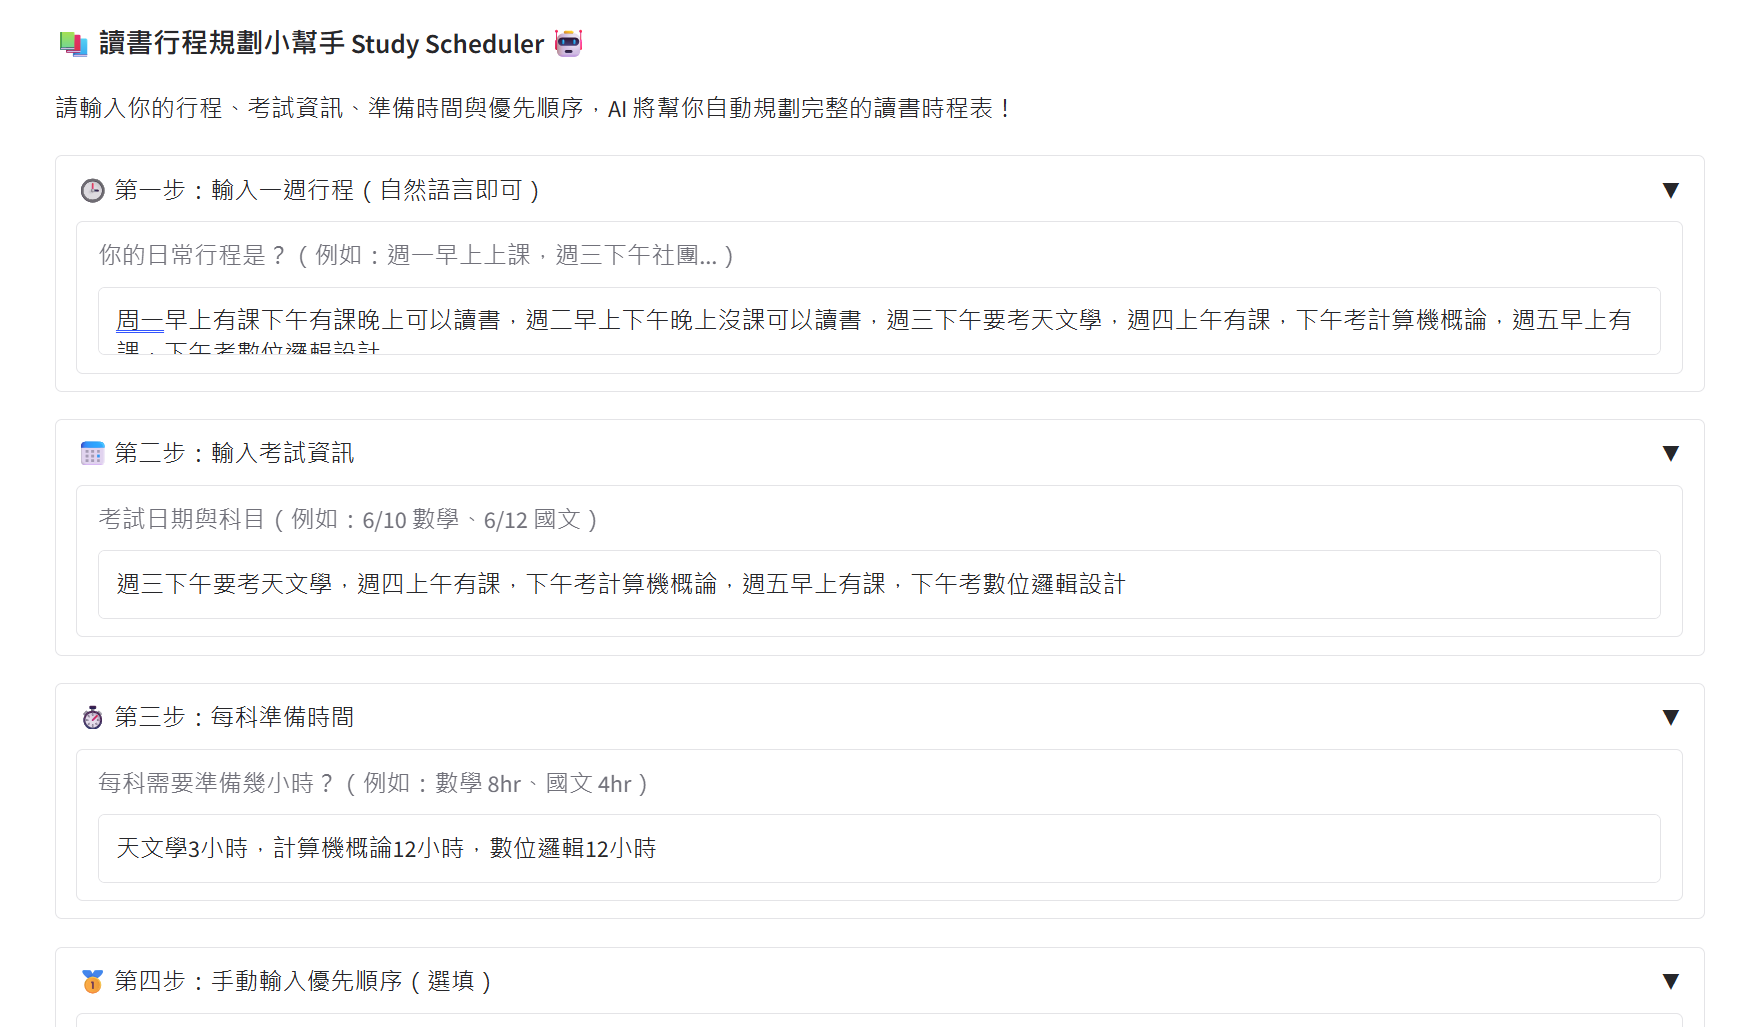
- 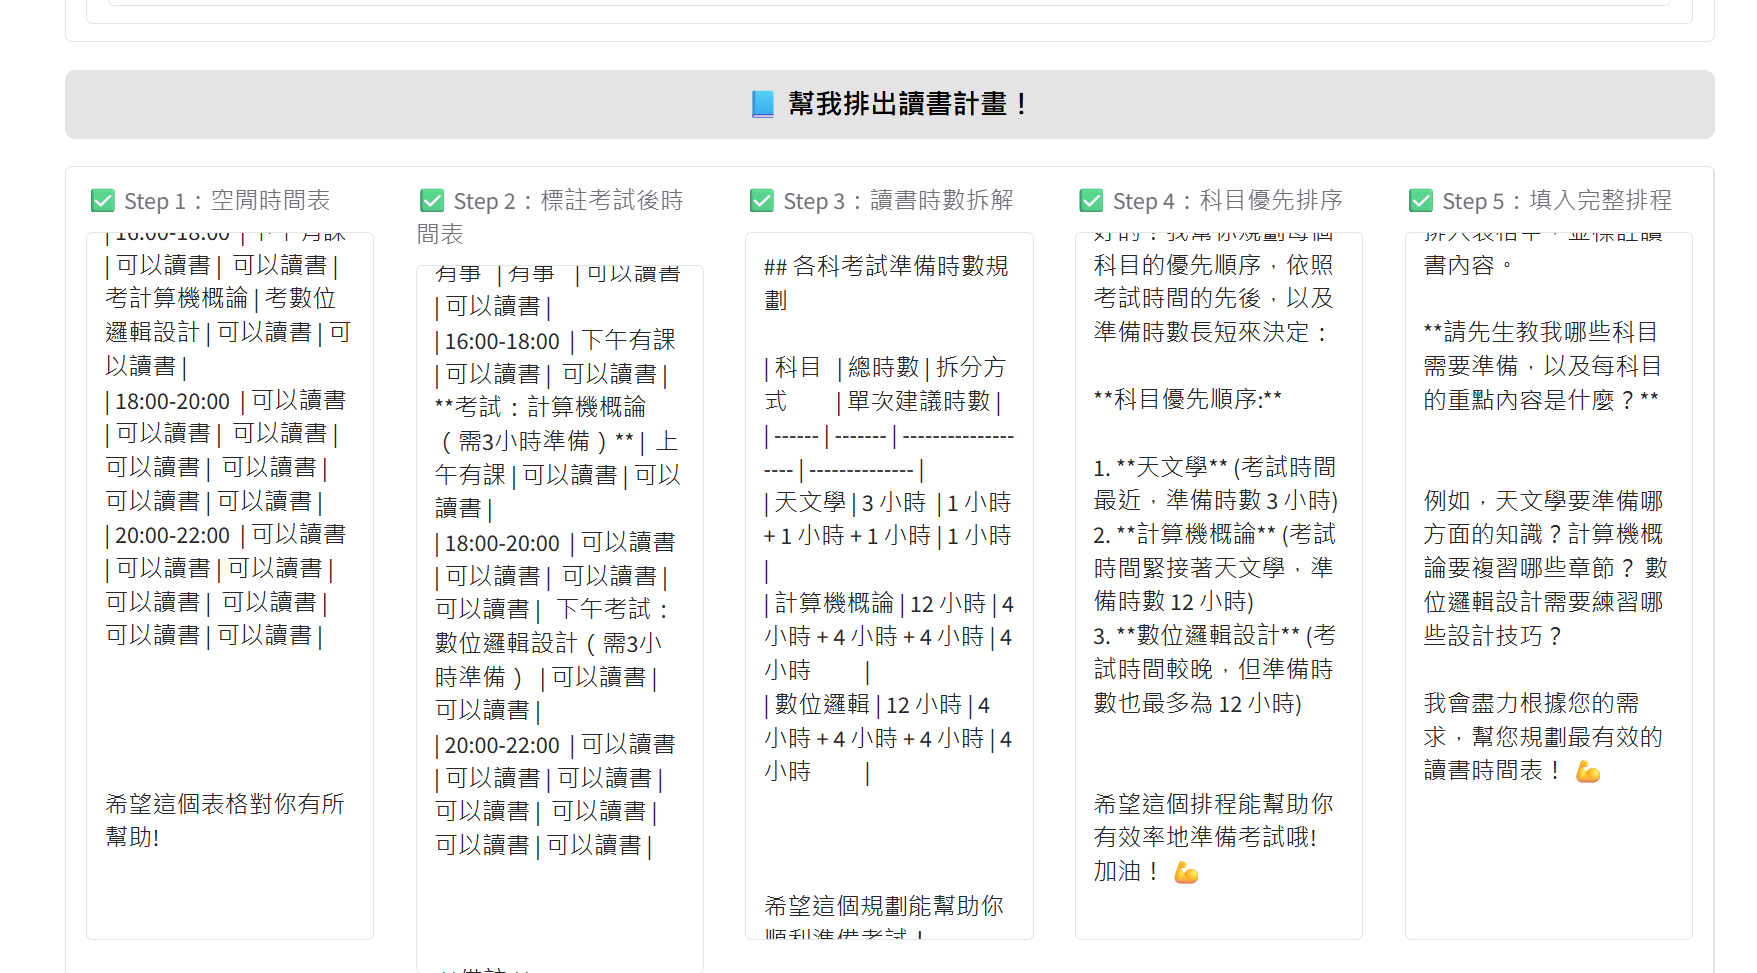
- 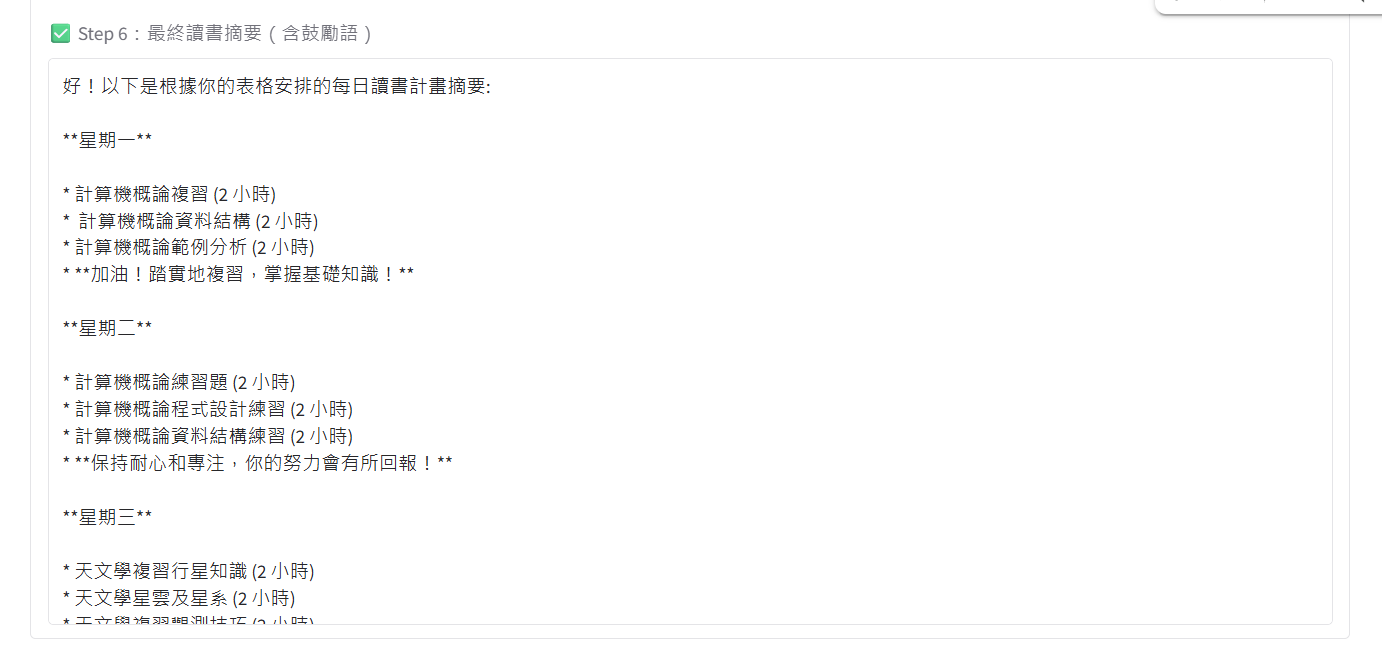

- 我覺得可能是模型不夠好，或是我的分工要再細一點，才能完整輸出我想要的一週七天任務規劃

## 程式碼

#### 1. 讀入你的金鑰

請依你使用的服務, 決定讀入哪個金鑰

In [34]:
import os
from google.colab import userdata

In [35]:
#【使用 Groq】
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key
provider = "groq"
model = "llama3-70b-8192"

In [ ]:
!pip install aisuite[all]

### 2. 使用 AISuite 的準備

In [37]:
import aisuite as ai

In [38]:
# provider_planner = "groq"
# model_planner="llama3-70b-8192"

# provider_writer = "groq"
# model_writer = "llama3-70b-8192"

provider_planner = "groq"
model_planner = "gemma2-9b-it"

provider_writer = "groq"
model_writer = "gemma2-9b-it"

#provider_reviewer = "openai"
#model_reviewer = "gpt-4o"

In [39]:
def reply(system="請用台灣習慣的中文回覆。",
          prompt="Hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

####  3. 打造二階段

In [40]:
system_timeScanner = "請務必用台灣習慣的中文回應: 你是一個擅長規劃時間的小助理，請幫我將這些資訊整理成一個 7x12 的表格，每格代表兩小時。如果有事情就標 '有事'，沒排事情的時間就標 '可以讀書'。」"
system_examMarker = "請務必用台灣習慣的中文回應: 你是一個擅長規劃時間的小助理，請幫我在有考試的時段標註『考試：科目名（需X小時準備）』。請使用相同格式輸出。"
system_studySlicer ="請務必用台灣習慣的中文回應: 你是一個擅長規劃時間的小助理，請幫我將這些資訊整理成一個表格輸出格式如下：科目｜總時數｜拆分方式｜單次建議時數"
system_priorityPlanner = "請務必用台灣習慣的中文回應: 你是一個擅長規劃時間的小助理，請提供一份清單：科目｜優先順序｜原因"
system_studyScheduler = "請務必用台灣習慣的中文回應: 你是一個擅長規劃時間的小助理，每次安排間最好間隔一天以上。注意：考試當時段不安排讀書。"
system_summaryWriter = "請務必用台灣習慣的中文回應：你是一個擅長規劃時間的小助理。根據輸入的表格，請整理出每日讀書計畫，格式使用 Markdown。請列出每天讀什麼科目、幾小時，並附上鼓勵語。若有衝突或安排不足，也請加註說明。"


In [41]:
def lucky_post(spacetime, testtime, studytime, priority):
    # Step 1:timeScanner
    timeScanner_prompt = f"使用者說：這是我最近一週的生活行程：{spacetime}。請幫我整理成一個 7x12 表格，每格代表兩小時，標註『有事』或『可以讀書』。"
    timeScanner_result = reply(system_timeScanner, timeScanner_prompt,
                               provider = provider_planner,
                               model = model_planner
                               )
    # Step 2:examMarker
    examMarker_prompt = f"使用者說:根據這份時間表{timeScanner_result}，請幫我在有考試的時段{testtime}標註『考試：科目名（需X小時準備）』。請使用相同格式輸出。"
    examMarker_result = reply(system_examMarker, examMarker_prompt,
                              provider = provider_planner,
                              model = model_planner
                              )
    # Step 3:studySlicer
    studySlicer_prompt = f"使用者說:以下是每科考試所需準備的時數{studytime}，請你將它們拆解成合理區段（例如：8小時可以拆成 3+3+2），並附註建議每次學習幾小時最合適。"
    studySlicer_result = reply(system_studySlicer, studySlicer_prompt,
                               provider = provider_planner,
                               model = model_planner
                               )
    # Step 4:priorityPlanner
    priorityPlanner_prompt = f"使用者說:根據考試時間的先後{examMarker_result}、準備時間的長短{studySlicer_result}，幫我將每個科目排出一個優先順序，數字越小代表越重要。"
    priorityPlanner_result = reply(system_priorityPlanner, priorityPlanner_prompt,
                                   provider = provider_planner,
                                   model = model_planner
                                   )
    # Step 5:studyScheduler
    studyScheduler_prompt = f"使用者說:根據這份空閒時間表{examMarker_result}、科目優先順序{priorityPlanner_result}與每科拆解時段{studySlicer_result}，請將每段學習時間依照優先順序排入表格中，並標註讀書內容。"
    studyScheduler_result = reply(system_studyScheduler, studyScheduler_prompt,
                                  provider = provider_planner,
                                  model = model_planner
                                  )
    # Step 6:summaryWriter
    summaryWriter_prompt = f"使用者說:請根據以下表格{studyScheduler_result}，幫我整理出一份可讀性高的讀書計畫摘要，格式清楚，列出每天讀什麼科目、幾小時，並附上鼓勵語。"
    summaryWriter_result = reply(system_summaryWriter, summaryWriter_prompt,
                                 provider = provider_planner,
                                 model = model_planner
                                 )

    return timeScanner_result, examMarker_result, studySlicer_result, priorityPlanner_result, studyScheduler_result, summaryWriter_result

### 3. 用 Gradio 打造你的對話機器人 Web App!

In [42]:
!pip install gradio

In [43]:
import gradio as gr

In [46]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("### 📚 讀書行程規劃小幫手 Study Scheduler 🤖")
    gr.Markdown("請輸入你的行程、考試資訊、準備時間與優先順序，AI 將幫你自動規劃完整的讀書時程表！")

    with gr.Accordion("🕒 第一步：輸入一週行程（自然語言即可）", open=True):
        spacetime = gr.Textbox(label="你的日常行程是？（例如：週一早上上課，週三下午社團...）")

    with gr.Accordion("📅 第二步：輸入考試資訊", open=True):
        testtime = gr.Textbox(label="考試日期與科目（例如：6/10 數學、6/12 國文）")

    with gr.Accordion("⏱️ 第三步：每科準備時間", open=True):
        studytime = gr.Textbox(label="每科需要準備幾小時？（例如：數學 8hr、國文 4hr）")

    with gr.Accordion("🥇 第四步：手動輸入優先順序（選填）", open=False):
        priority = gr.Textbox(label="若想指定優先順序，請輸入格式：數學：1、國文：2")

    btn = gr.Button("📘 幫我排出讀書計畫！")

    with gr.Row():
        out1 = gr.Textbox(label="✅ Step 1：空閒時間表")
        out2 = gr.Textbox(label="✅ Step 2：標註考試後時間表")
        out3 = gr.Textbox(label="✅ Step 3：讀書時數拆解")
        out4 = gr.Textbox(label="✅ Step 4：科目優先排序")
        out5 = gr.Textbox(label="✅ Step 5：填入完整排程")
        out6 = gr.Textbox(label="✅ Step 6：最終讀書摘要（含鼓勵語）")

    btn.click(fn=lucky_post, inputs=[spacetime, testtime, studytime, priority],
              outputs=[out1, out2, out3, out4, out5, out6])


In [47]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4a4165261abda29dc6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4a4165261abda29dc6.gradio.live
